In [1]:
! git clone https://github.com/huggingface/diffusers.git

'git' is not recognized as an internal or external command,
operable program or batch file.


In [1]:
import torch
import matplotlib.pyplot as plt
import random
import asyncio
import threading
from librosa.beat import beat_track
from pythonosc import dispatcher, osc_server
import numpy as np
from datasets import load_dataset
from diffusers import DiffusionPipeline, DDIMScheduler, AudioDiffusionPipeline
from diffusers_local import UNet2DModel as UNet2DModel_local
import soundfile as sf
from CreateDataset import AudioProcessor
from NetworkBending import NetworkBending
import time

osc_lock = threading.Lock()

NB = NetworkBending()

device = "cuda" if torch.cuda.is_available() else "cpu"
audio_diffusion = DiffusionPipeline.from_pretrained("teticio/audio-diffusion-ddim-256")
# apply the custom unet model so we can Networkbend the audio
audio_diffusion.unet = UNet2DModel_local.from_pretrained("teticio/audio-diffusion-ddim-256", subfolder="unet", network_bending=NB)

#set the scheduler to DDIM
audio_diffusion.scheduler = DDIMScheduler.from_pretrained("teticio/audio-diffusion-ddim-256", subfolder="scheduler")
audio_diffusion.to(device)

#ds = load_dataset('teticio/audio-diffusion-256')
generator=torch.Generator(device="cpu").manual_seed(42)

alpha = 0
latent1 = 0
latent2 = 1
diffusion_steps = 10
make_loop = 0

c:\Users\danhearn\.conda\envs\diffusertrack\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\danhearn\.conda\envs\diffusertrack\Lib\site-packages\kornia\feature\lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)
c:\Users\danhearn\.conda\envs\diffusertrack\Lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)
unet\diffusion_pytorch_model.safetensors not found
Loading pipeline components...:   0%|          | 0/3 [00:00<?, ?it/s]An error occurred while trying to fetch C:\Users\danhear

In [2]:
# Load audio and process it into 5 second spectrograms
input_dir = r"C:\\Users\\danhearn\\Music"
processor = AudioProcessor(input_dir)
processor.process_directory()

unet\diffusion_pytorch_model.safetensors not found
Loading pipeline components...:   0%|          | 0/3 [00:00<?, ?it/s]An error occurred while trying to fetch C:\Users\danhearn\.cache\huggingface\hub\models--teticio--audio-diffusion-ddim-256\snapshots\f5606c5138496ecdcbd096a4446eb6d03ae690cb\unet: Error no file named diffusion_pytorch_model.safetensors found in directory C:\Users\danhearn\.cache\huggingface\hub\models--teticio--audio-diffusion-ddim-256\snapshots\f5606c5138496ecdcbd096a4446eb6d03ae690cb\unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
Loading pipeline components...: 100%|██████████| 3/3 [00:00<00:00, 19.50it/s]


In [3]:
def loop_it(audio: np.ndarray,
        sample_rate: int,
        loops: int = 1) -> np.ndarray:
    """Loop audio

    Args:
        audio (np.ndarray): audio as numpy array
        sample_rate (int): sample rate of audio
        loops (int): number of times to loop

    Returns:
        (float, np.ndarray): sample rate and raw audio or None
    """
    _, beats = beat_track(y=audio, sr=sample_rate, units='samples')
    for beats_in_bar in [16, 12, 8, 4]:
        if len(beats) > beats_in_bar:
            return np.tile(audio[beats[0]:beats[beats_in_bar]], loops)
    return None

def interpolation(address, *args):
    
    """Interpolate between two latents for generation
    Args:
        address (str): OSC address
        *args: OSC arguments
    """

    global alpha, latent1, latent2
    
    if address == "/alpha":
        alpha = args[0]
    if address == "/latent1" and latent2 != args[0]:
        latent1 = int(args[0])
    if address == "/latent2" and latent1 != args[0]:
        latent2 = int(args[0])

def inference(address, *args):

    """Control the inference process
    Args:
        address (str): OSC address
        *args: OSC arguments
    """

    global diffusion_steps, make_loop

    if address == "/steps":
        diffusion_steps = int(args[0])
    if address == "/loop":
        make_loop = int(args[0])

In [7]:
#load 20 images from the default dataset
ds = load_dataset('teticio/audio-diffusion-256')
images = []

for i in range(20):
    images.append(random.choice(ds['train'])['image'])

images[0].show()


In [4]:
import os
from PIL import Image
import torch
import numpy as np

# Assuming `audio_diffusion` is your Diffusion model pipeline
encoded_images = []

# Directory containing mel spectrograms
spectrogram_dir = "data/mel_spectrograms"

# Loop through each file in the directory
for i, file_name in enumerate(os.listdir(spectrogram_dir)):
    spectrogram_path = os.path.join(spectrogram_dir, file_name)
    spectrogram_image = Image.open(spectrogram_path).convert("L")
    encoded_image = audio_diffusion.encode([spectrogram_image], steps=100)
    encoded_images.append(encoded_image)
    if i >= 10:
        break


  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\danhearn\Documents\GitHub\diffusertrack\diffusers_local\models\attention_processor.py:2367: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  hidden_states = F.scaled_dot_product_attention(
100%|██████████| 100/100 [00:04<00:00, 23.12it/s]


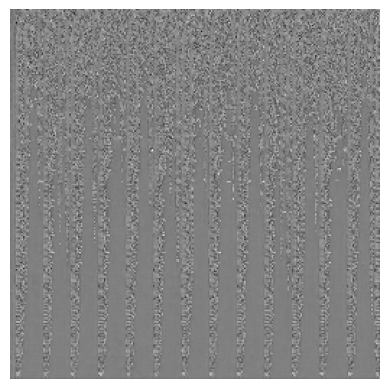

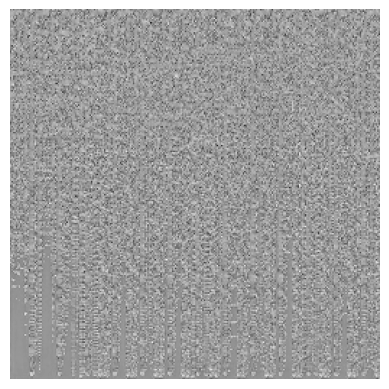

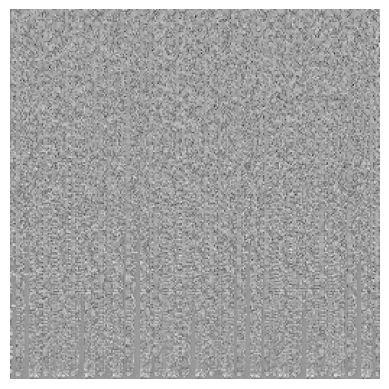

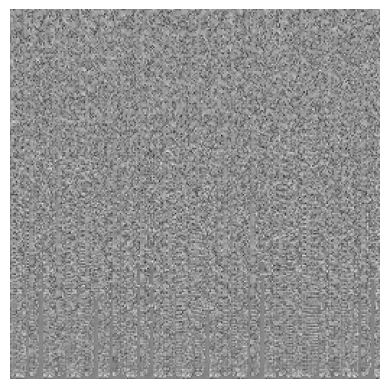

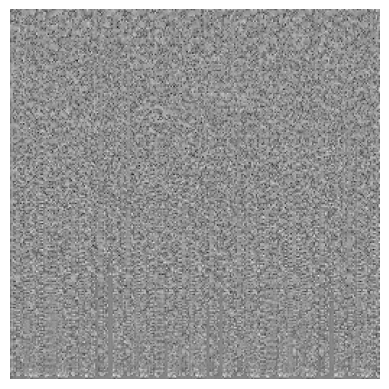

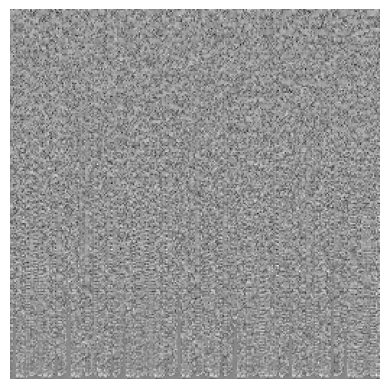

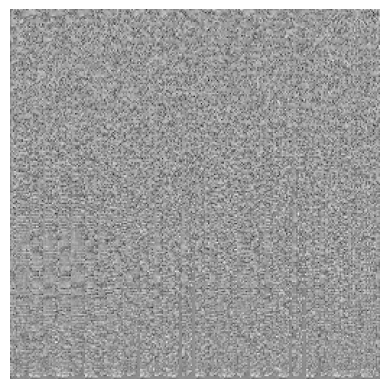

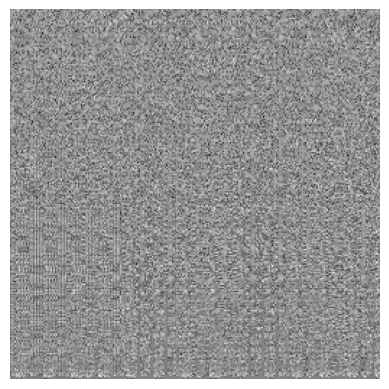

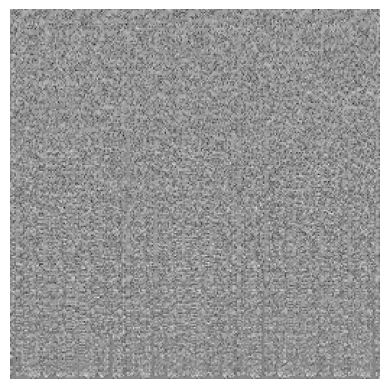

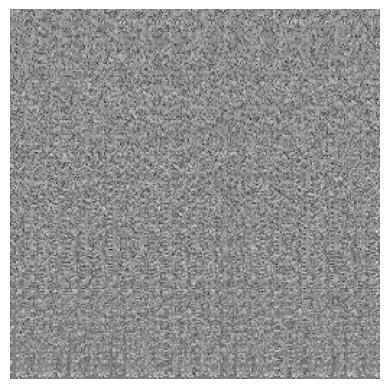

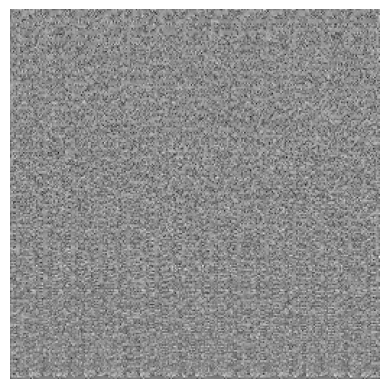

In [6]:
for encoded_image in encoded_images:
    plt.imshow(encoded_image.cpu().squeeze(), cmap='gray')
    plt.axis('off')  # Hide axes
    plt.show()
    

In [5]:
#osc listener
from pythonosc import dispatcher, osc_server

ip="127.0.0.1"
port=9999

d = dispatcher.Dispatcher()
# Map incoming OSC messages to the osc_receive method
d.map("/rotate_x_radian",  NB.osc_receive)
d.map("/rotate_y_radian", NB.osc_receive)
d.map("/rotate_z_radian", NB.osc_receive)
d.map("/rotate_x_scaling_factor", NB.osc_receive)
d.map("/rotate_y_scaling_factor", NB.osc_receive)
d.map("/rotate_z_scaling_factor", NB.osc_receive)
d.map("/scale_factor", NB.osc_receive)
d.map("/layer", NB.osc_receive)
d.map("/scale", NB.osc_receive)
d.map("/reflect", NB.osc_receive)
d.map("/erosion", NB.osc_receive)
d.map("/dilation", NB.osc_receive)
d.map("/gradient", NB.osc_receive)
d.map("/sobel", NB.osc_receive)
d.map("/add_rand_rows", NB.osc_receive)
d.map("/normalize", NB.osc_receive)
d.map("/rotate_x", NB.osc_receive)
d.map("/rotate_y", NB.osc_receive)
d.map("/rotate_z", NB.osc_receive)
d.map("/alpha", interpolation)
d.map("/latent1", interpolation)
d.map("/latent2", interpolation)
d.map("/steps", inference)
d.map("/loop", inference)

s = osc_server.ThreadingOSCUDPServer((ip, port), d)

osc_thread = threading.Thread(target=s.serve_forever)
osc_thread.daemon = True # This will allow the main program to exit even if the OSC server is still running
osc_thread.start()
print("OSC server started - listening on port 9999")

OSC server started - listening on port 9999


In [ ]:
# Main loop for image generation
try:
    while True:
        with osc_lock: 
             
            output = audio_diffusion(steps=diffusion_steps,
            noise=AudioDiffusionPipeline.slerp(encoded_images[latent1], encoded_images[latent2], alpha),
            generator=generator, eta=0)

            output.images[0].save("generated_image.png")
            audio = output.audios[0, 0]

            if make_loop == 1:
                loop = loop_it(audio, audio_diffusion.mel.get_sample_rate())
                sf.write("output_audio.wav", loop, audio_diffusion.mel.get_sample_rate())
            elif make_loop == 0:
                time.sleep(0.05)
                sf.write("output_audio.wav", audio, audio_diffusion.mel.get_sample_rate())



except KeyboardInterrupt:
    s.shutdown()
    print("Terminating the loop gracefully.")

100%|██████████| 10/10 [00:00<00:00, 42.35it/s]
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x000002149DDDDF90>>
Traceback (most recent call last):
  File "c:\Users\danhearn\.conda\envs\diffusertrack\Lib\site-packages\ipykernel\ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 
100%|██████████| 10/10 [00:00<00:00, 41.69it/s]
